In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MaxPool2D, Conv2D, Flatten
from keras import utils #utils.to_categorical()
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [2]:
# イタリア語表記 -> 英語表記
translate = {"farfalla": "butterfly",
             "gatto": "cat",
             "gallina": "chicken",
             "mucca": "cow",
             "cane": "dog",
             "elefante": "elephant",
             "cavallo": "horse",
             "pecora": "sheep",
             "ragno": "spider",
             "scoiattolo": "squirrel"}

# 各ファイルパス取得
img_dir = {}
class_count = {}
for name in translate.keys():
    files = glob.glob('../input/animals10/raw-img/' + name + '/*.jpeg')
    img_dir[translate[name]] = files
    class_count[translate[name]] = len(files)

In [4]:
img_dir.keys()

dict_keys(['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel'])

In [5]:
img_dir['butterfly'][:5]

['../input/animals10/raw-img/farfalla/OIP-PeE0HgAy1QOlr2oGZJ8ytQHaGX.jpeg',
 '../input/animals10/raw-img/farfalla/OIP-hUrjT_QVKNSz8hBaRr_LmQHaLH.jpeg',
 '../input/animals10/raw-img/farfalla/OIP-YNqBf_ZQHJthXHKsk-UE2wHaF7.jpeg',
 '../input/animals10/raw-img/farfalla/OIP-4O2nl45jJNRTiSHP-wt6yAHaFS.jpeg',
 '../input/animals10/raw-img/farfalla/OIP-AbT7F0AMQ_bOghc7sJShSwHaEK.jpeg']

# データセット分析・可視化

butterfly : 1650
cat       : 1227
chicken   : 3098
cow       : 1866
dog       : 4863
elephant  : 1079
horse     : 2623
sheep     : 1444
spider    : 4497
squirrel  : 1862
-----------------
sum       : 24209


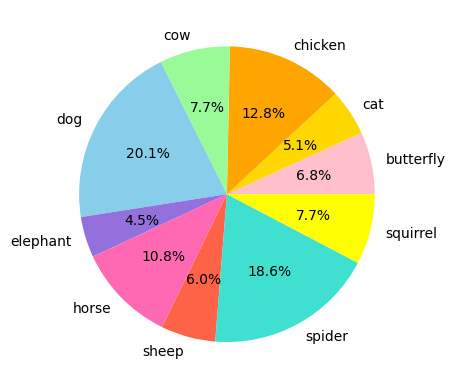

In [34]:
# クラス比率
colors = ["#FFC0CB", "#FFD700", "#FFA500", "#98FB98", "#87CEEB",
          "#9370DB", "#FF69B4", "#FF6347", "#40E0D0", "#FFFF00"]
plt.pie(class_count.values(), labels=class_count.keys(), autopct="%1.1f%%", colors=colors)
for name, val in class_count.items():
    print('{:<10}: {}'.format(name, val))
print('-----------------')
print('sum       : {}'.format(sum(class_count.values())))

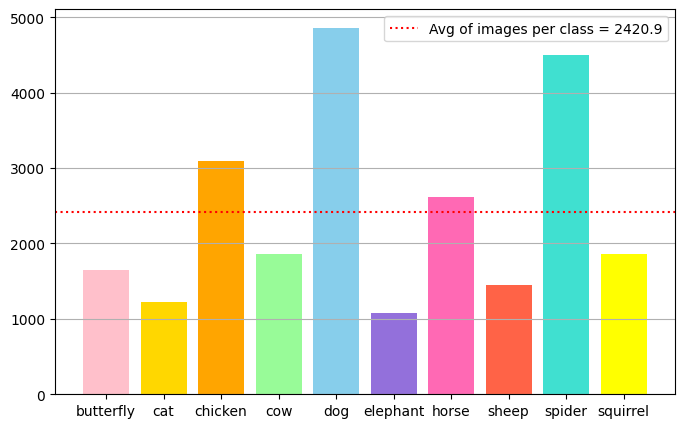

In [73]:
# 棒グラフ
plt.figure(figsize=(8,5))
plt.grid(axis='y')
plt.bar(list(range(len(class_count))),
        class_count.values(),
        tick_label=list(class_count.keys()),
        color=colors)
plt.axhline(np.mean(list(class_count.values())),
            linestyle=':',
            color='r',
            label=f'Avg of images per class = {np.mean(list(class_count.values()))}')
plt.legend()

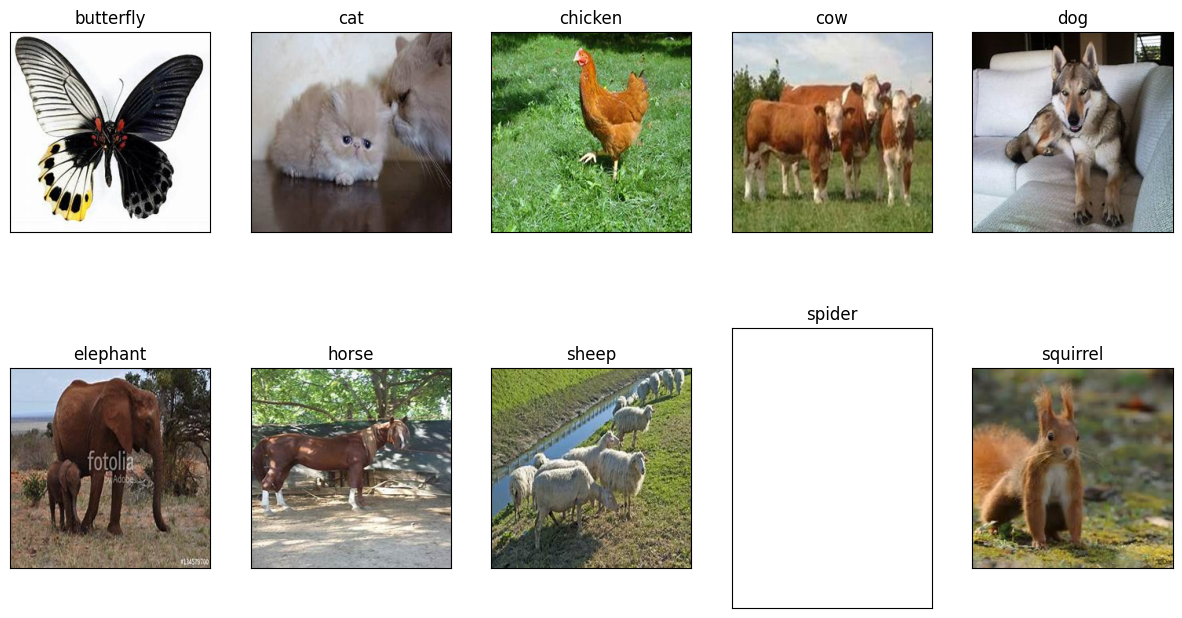

In [13]:
# 画像表示
# 各画像のサイズはバラバラで縦横ともにおおよそ200~300くらい
fig, axes = plt.subplots(2, 5, figsize=(15,8), subplot_kw={'xticks': (), 'yticks': ()})
for ax, (name, imgs) in zip(axes.ravel(), img_dir.items()):
    for im in imgs[:1]:
        im = Image.open(im) #PILとして取得 (型: PIL)
        im_resize = im.resize((256, 256)) #リサイズ
        if name != 'spider':
            ax.imshow(im_resize)
        ax.set_title(name)

# データ前処理

In [6]:
# 画像ファイル(jpeg) -> 3次元Numpyに変換
# OpenCVで取得するとndarrayとして取得可能であるがPILと計算時間は同じ
def img_to_arr(img):
    img = Image.open(img) #PILとして取得
    img = img.resize((32, 32)) #リサイズ
    return np.array(img)

In [7]:
# 画像およびラベルを取得
images = np.empty(0, dtype='int64') #すべての画像データ
labels = np.empty(0, dtype='int64') #画像データのラベル

for i, imgs in enumerate(img_dir.values()):
    print(i, end='')
    for img in imgs:
        images = np.append(images, img_to_arr(img))
        labels = np.append(labels, np.array(i))

images = images.reshape(24209, 32, 32, 3)
labels = labels.reshape(-1, 1)

0123456789

In [8]:
# ファイル保存
'''
・Animals-10に含まれる各ファイルはjpeg形式であるため, Numpyとして取得するには PIL または OpenCV を用いる
・24209枚の画像をNumpyに変換するのは上記2つの方法どちらでも非常に時間がかかる(およそ50分ほど)
・そこで, Numpyに変換したデータを次回以降ですぐに使用できるようファイルとして保存
'''
np.save('/kaggle/working/images', images)
np.save('/kaggle/working/labels', labels)

In [2]:
# データロード (オフライン拡張前)
images = np.load('/kaggle/input/images-and-labels/images.npy')
labels = np.load('/kaggle/input/images-and-labels/labels.npy')

In [3]:
# 訓練/テスト層化分割
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, random_state=0, stratify=labels)

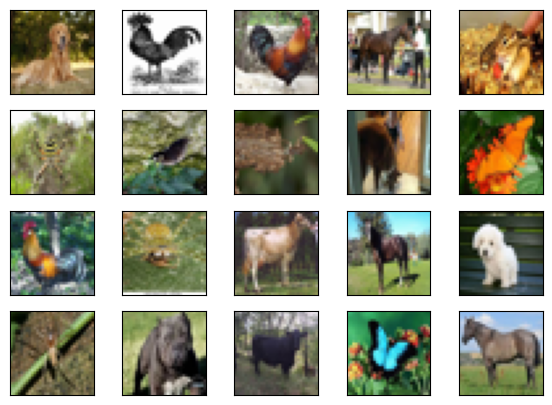

In [16]:
fig, axes = plt.subplots(4, 5, figsize=(7,5), subplot_kw={'xticks': (), 'yticks': ()})
for ax, img in zip(axes.ravel(), X_train[:30]):
    ax.imshow(img)

In [4]:
# ラベルをバイナリクラスに変換 (Kerasに必要な処理)
y_train_categorical = utils.to_categorical(y_train, 10)
y_test_categorical = utils.to_categorical(y_test, 10)
y_train_categorical[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

# Kerasを使用したCNN
* オートエンコーダの実装方法と似ているようで色々異なるため注意 (特に訓練/テストデータやバッチサイズの指定タイミング)
* 拡張ありなしを比較

CNNの各層の役割
* 畳み込み層: 画像内のエッジや色の変化といった局所的特徴を捉える
* プーリング層: 位置的な情報を削ぎ落とす (猫が画像内の上下左右どこにいても猫と識別できるように)
* 全結合層: 前層(一次元)をすべて結合(一次元). 例えば 5(h) -> 20(u) にノードを増やす場合, 20uの各ノードu_xは5hの線形結合(u_x = W*h_(1-5) + b)となる

In [ ]:
'''
# Conv2Dのパラメータ
tf.keras.layers.Conv2D(
    filters,                                # 使用するフィルタ(カーネル)数. 各層で出力される特徴量マップ数と等しくなる 
    kernel_size,                            # フィルタサイズ
    strides=(1, 1),                         # ストライド
    padding='valid',                        # パディング. validはパディング無し, sameはゼロパディングを行い畳み込み前後で画像の大きさが変化しない
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,                        # 活性化関数
    use_bias=True,                          # バイアスベクトルの有無 (線形変換 u = W*h + b の b(切片)部分)
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)
'''

In [8]:
# モデル構築                                                                縦*横*チャネル数
inp = Input(shape=(32, 32, 3))                                     # 入力: 32*32*3 (横*縦*RGBチャネル)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(inp)     # 出力: 32*32*64 (ゼロパディングにより画像サイズが変わらない)
x = MaxPool2D(pool_size=(2, 2))(x)                                 # 出力: 16*16*64 (2*2プーリングより画像サイズが半分に変化)
x = Conv2D(128, (3, 3), padding='same', activation="relu")(x)      # 出力: 16*16*128
x = MaxPool2D(pool_size = (2, 2))(x)                               # 出力: 8*8*128
x = Conv2D(256, (3, 3), padding='same', activation="relu")(x)      # 出力: 8*8*256
x = MaxPool2D(pool_size=(2,2))(x)                                  # 出力: 4*4*256
x = Conv2D(512, (3, 3), padding='same', activation="relu")(x)      # 出力: 4*4*512
x = Flatten()(x)                                                   # 多次元(4*4*512) -> 一次元(8192) に変換 
x = Dense(512, activation='relu')(x)                               # 入力: 8192 -> 出力: 512
out = Dense(10, activation='softmax')(x)                           # 入力: 512 -> 出力: 10 -> ソフトマックス関数: 10個の値の和が1になるように変換

↓↓↓ オフライン拡張× オンライン拡張× ↓↓↓

In [9]:
# モデルコンパイル(拡張なし)
normal_model = Model(inputs=inp, outputs=out)
normal_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #損失関数: 多クラスクロスエントロピー, 評価基準: 複数選択可能

In [10]:
# 正規化モデル定義(訓練用)
normal_train_datagen = ImageDataGenerator(rescale=1./255) #画素値0~255を0~1に変換
normal_train_generator = normal_train_datagen.flow(X_train, y_train_categorical, batch_size=32, seed=0) #X/y/バッチサイズはここで指定

# 正規化モデル定義(テスト用)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(X_test, y_test_categorical, batch_size=32, seed=0)

In [28]:
# モデル学習
# steps_per_epoch: 1エポックごとにおける重みの変更回数 *通常(None)「訓練データ数/バッチサイズ = バッチ数(イテレーション数)」となる
'''
・各エポックの実行時間がおかしい? (2分前後と1秒未満を繰り返している)
・あるエポックの学習終了後, 次のエポックへ移動するのに時間がかかっている
・実行時間も30分ほどかかったがこれは普通?
'''
normal_result = normal_model.fit(normal_train_generator, epochs=20)

Epoch 1/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 95s 155ms/step - accuracy: 0.2512 - loss: 2.0741
Epoch 2/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 0s 23us/step - accuracy: 0.5312 - loss: 0.8022   
Epoch 3/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 140s 152ms/step - accuracy: 0.4728 - loss: 1.5076
Epoch 4/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 0s 9us/step - accuracy: 0.5625 - loss: 0.6581    
Epoch 5/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 143s 154ms/step - accuracy: 0.5769 - loss: 1.2314
Epoch 6/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.5625 - loss: 0.5860   
Epoch 7/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 142s 156ms/step - accuracy: 0.6399 - loss: 1.0502
Epoch 8/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.4375 - loss: 0.6186   
Epoch 9/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 142s 156ms/step - accuracy: 0.6949 - loss: 0.8842
Epoch 10/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 0s 12us/step - accuracy: 0.7188 - loss: 0.4648   
Epoch 11/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 140s 154ms/step - accuracy: 0.7675 - loss: 0.6781
Epoch 12/

Text(0, 0.5, 'Accuracy')

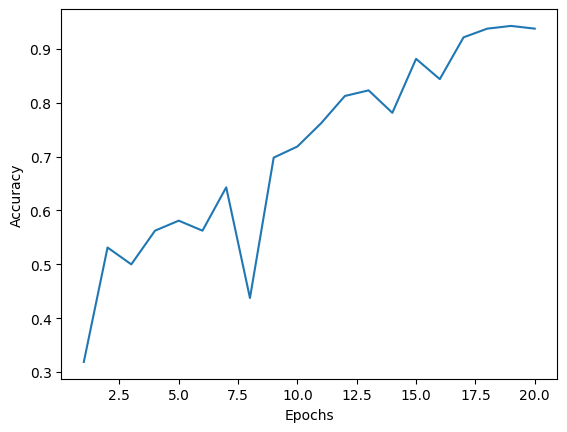

In [32]:
# 各エポックごとのaccuracyのプロット
# ガタガタしているが何があった?
plt.plot(range(1, 21), normal_result.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [30]:
# テスト
# 大きく過学習が発生している
normal_evaluate = normal_model.evaluate(test_generator)

152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6488 - loss: 1.8185


↓↓↓ オフライン拡張× オンライン拡張〇 ↓↓↓

In [17]:
# モデルコンパイル(オンライン拡張)
augmentation_model = Model(inputs=inp, outputs=out)
augmentation_model.compile(optimizer='adam', loss ='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
'''
# データオーグメンテーション一覧
ImageDataGenerator(rotation_range=x,        #回転 -x(int)度 ~ x度
                   width_shift_range=x,     #左右平行移動(割合) -x(float) ~ x (0.5なら画像内を半分動く)
                   height_shift_range=x,    #上下平行移動(割合) -x(float) ~ x
                   zoom_range=[x, y],       #拡大縮小(割合) x(float) ~ y
                   shear_range=x,           #せん断 x(float) x度
                   horizontal_flip=True,    #左右反転
                   vertical_flip=True,      #上下反転
                   brightness_range=[x, y], #明るさ(<1:暗, >1:明)) x(float) ~ y
                   channel_shift_range=x    #画素値(0~255)を変更 -x(float) ~ +x
                   rescale=1./255           #リスケーリング
                  )

# 補間方法: fill_mode
nearest    #一番近くの画素値で補間 (デフォルト)
constant   #定数で補間
reflect    #反転して補間
wrap       #繰り返しで補間
'''

In [18]:
# オーグメンテーションモデル定義
augmentation_train_datagen = ImageDataGenerator(
    rotation_range=5,             #回転
    width_shift_range=0.3,        #左右平行移動
    height_shift_range=0.2,       #上下平行移動
    zoom_range=[0.8, 1.2],        #拡大縮小
    horizontal_flip=True,         #左右反転
    brightness_range=[0.8, 1.2],  #明るさ
    channel_shift_range=5,        #画素値変更
    rescale=1./255                #スケーリング
    )

# バッチ化
augmentation_train_generator = augmentation_train_datagen.flow(X_train,
                                                               y_train_categorical,
                                                               batch_size=32,
                                                               seed=0)

In [19]:
# 学習
augmentation_result = augmentation_model.fit(augmentation_train_generator, epochs=20)

Epoch 1/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 148s 240ms/step - accuracy: 0.2332 - loss: 2.1336
Epoch 2/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 146s 241ms/step - accuracy: 0.3624 - loss: 1.7990
Epoch 3/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 202s 241ms/step - accuracy: 0.4386 - loss: 1.6160
Epoch 4/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 204s 245ms/step - accuracy: 0.4803 - loss: 1.5075
Epoch 5/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 201s 243ms/step - accuracy: 0.5143 - loss: 1.4134
Epoch 6/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 201s 242ms/step - accuracy: 0.5475 - loss: 1.3235
Epoch 7/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 144s 237ms/step - accuracy: 0.5554 - loss: 1.2943
Epoch 8/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 201s 236ms/step - accuracy: 0.5672 - loss: 1.2591
Epoch 9/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 202s 236ms/step - accuracy: 0.5825 - loss: 1.2171
Epoch 10/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 202s 236ms/step - accuracy: 0.6056 - loss: 1.1709
Epoch 11/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 203s 238ms/step - accuracy: 0.6081 - loss: 1.1511
Epoch 12

Text(0, 0.5, 'Accuracy')

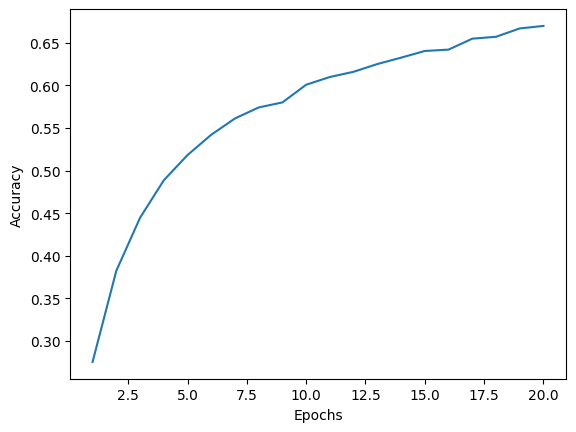

In [20]:
# 各エポックごとのaccuracyのプロット
# ガタガタはなくなった一方, 訓練スコアは低下(オーグメンテーションによる影響)
plt.plot(range(1, 21), augmentation_result.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [21]:
# テスト
# データオーグメンテーション前よりも低下
# クラス間データ数の偏りによる影響が強い?
augmentation_evaluate = augmentation_model.evaluate(test_generator)

152/152 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.6297 - loss: 1.1304


↓↓↓ オフライン拡張〇 オンライン拡張〇 ↓↓↓

In [47]:
# オフライン拡張
datagen = ImageDataGenerator(
    rotation_range=5,             #回転
    width_shift_range=0.3,        #左右平行移動
    height_shift_range=0.2,       #上下平行移動
    zoom_range=[0.8, 1.2],        #拡大縮小
    horizontal_flip=True,         #左右反転
    brightness_range=[0.8, 1.2],  #明るさ
    channel_shift_range=5,        #画素値変更
    # リスケールは無視される
    )

In [85]:
# すべてのラベルのデータ数が等しくなるまで拡張
class_counts = np.bincount(y_train.reshape(1, -1)[0]) #ラベルごとのデータ数
max_class_count = np.max(class_counts) #最大データ数
oversample_counts = max_class_count - class_counts #オーバーサンプリング数を計算

In [88]:
# オーバーサンプリング
oversampled_X = np.empty(0, dtype='int64')
oversampled_y = np.empty(0, dtype='int64')

for i, count in enumerate(oversample_counts):
    print(i, end='')
    if count == 0: #最大データ数を持つクラスをスキップ
        continue
    
    indices = np.where(y_train.reshape(1, -1)[0] == i)[0]
    for _ in range(count):
        img = X_train[np.random.choice(indices, 1)[0]] #ランダム抽出
        img = datagen.random_transform(img).astype('int64') #ランダム抽出した画像を拡張変換
        oversampled_X = np.append(oversampled_X, img)
        oversampled_y = np.append(oversampled_y, np.array(i))

0123456789

In [91]:
# 拡張前データと拡張後データを結合
oversampled_X = oversampled_X.reshape(oversample_counts.sum(), 32, 32, 3)
oversampled_y = oversampled_y.reshape(-1, 1)
X_train_augmented = np.concatenate([X_train, oversampled_X])
y_train_augmented = np.concatenate([y_train, oversampled_y])

In [95]:
np.bincount(y_train_augmented.reshape(1, -1)[0])

array([3890, 3890, 3890, 3890, 3890, 3890, 3890, 3890, 3890, 3890])

In [100]:
# ファイル保存
np.save('/kaggle/working/X_train_augmented', X_train_augmented)
np.save('/kaggle/working/y_train_augmented', y_train_augmented)

In [5]:
# ファイルロード (オフライン拡張後)
X_train_augmented = np.load('/kaggle/input/xy-train-augmented/X_train_augmented.npy')
y_train_augmented = np.load('/kaggle/input/xy-train-augmented/y_train_augmented.npy')

In [6]:
# ラベルをバイナリクラスに変換 (Kerasに必要な処理)
y_train_augmented_categorical = utils.to_categorical(y_train_augmented, 10)

In [104]:
# モデルコンパイル(オンライン拡張)
augmentation_model = Model(inputs=inp, outputs=out)
augmentation_model.compile(optimizer='adam', loss ='categorical_crossentropy', metrics=['accuracy'])

In [108]:
# オーグメンテーションモデル定義
augmentation_train_datagen = ImageDataGenerator(
    rotation_range=2,             #回転
    width_shift_range=0.05,       #左右平行移動
    height_shift_range=0.05,      #上下平行移動
    zoom_range=[0.9, 1.1],        #拡大縮小
    horizontal_flip=True,         #左右反転
    brightness_range=[0.9, 1.1],  #明るさ
    channel_shift_range=0.5,      #画素値変更
    rescale=1./255                #スケーリング
    )

# バッチ化
augmentation_train_generator = augmentation_train_datagen.flow(X_train_augmented,
                                                               y_train_augmented_categorical,
                                                               batch_size=32,
                                                               seed=0)

In [109]:
# 学習
# 訓練データ数38900 に対し, バッチサイズ32 より, 1iterにつき 38900/32=1215.6... となる
# 1216回回しているので, 1216回目のイテレーションは他と比較しデータ数が少ない
augmentation_result = augmentation_model.fit(augmentation_train_generator, epochs=20)

Epoch 1/20
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 280s 228ms/step - accuracy: 0.6795 - loss: 0.9401
Epoch 2/20
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 289s 237ms/step - accuracy: 0.7219 - loss: 0.8163
Epoch 3/20
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 318s 234ms/step - accuracy: 0.7385 - loss: 0.7526
Epoch 4/20
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 278s 228ms/step - accuracy: 0.7680 - loss: 0.6807
Epoch 5/20
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 274s 225ms/step - accuracy: 0.7867 - loss: 0.6248
Epoch 6/20
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 326s 229ms/step - accuracy: 0.8038 - loss: 0.5787
Epoch 7/20
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 319s 227ms/step - accuracy: 0.8179 - loss: 0.5370
Epoch 8/20
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 321s 226ms/step - accuracy: 0.8382 - loss: 0.4847
Epoch 9/20
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 322s 226ms/step - accuracy: 0.8504 - loss: 0.4518
Epoch 10/20
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 280s 230ms/step - accuracy: 0.8494 - loss: 0.4475
Epoch 11/20
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 322s 230ms/step - accuracy: 0.8650 -

Text(0, 0.5, 'Accuracy')

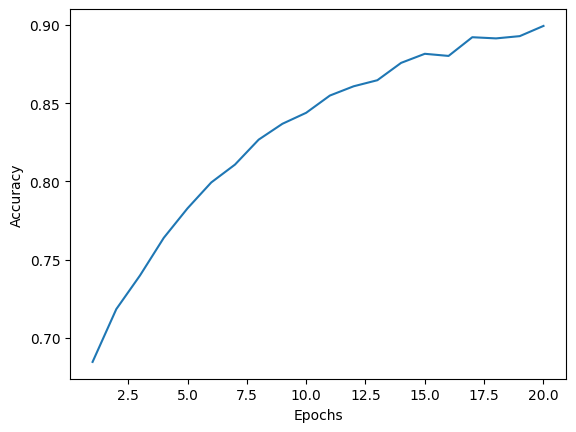

In [110]:
# 各エポックごとのaccuracyのプロット
plt.plot(range(1, 21), augmentation_result.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [111]:
# テスト
augmentation_evaluate = augmentation_model.evaluate(test_generator)

152/152 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.6913 - loss: 1.6370


# PyTorchを使用したCNN
* PyTorchのtensor型を使用すると, GPUを使用することができるためNumpyより高速に処理可能
* オフライン拡張〇 オンライン拡張× を試す

In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
# GPUが利用可能であれば, CUDAデバイスを使用する
# KaggleでGPUを使用するには左上3点マークからAcceleratorを選択
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
# CNN実装
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        
        self.dropout = nn.Dropout(0.5) #過学習対策でドロップアウトを導入 (全結合の前等)
        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        ''' 3*32*32 -> 64*16*16 '''
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        ''' 64*16*16 -> 128*8*8 '''
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        ''' 128*8*8 -> 256*4*4 '''
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        ''' 256*4*4 -> 512*4*4 '''
        x = self.conv4(x)
        x = self.relu(x)
        ''' 512*4*4 -> 8192 '''
        x = torch.flatten(x, 1) 
        ''' 8192 -> 512 '''
        x = self.dropout(x) #ドロップアウト
        x = self.fc1(x)
        x = self.relu(x)
        ''' 512 -> 10 '''
        x = self.dropout(x) #ドロップアウト
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [55]:
# Numpyデータロード (オフライン拡張)
images = np.load('/kaggle/input/images-and-labels/images.npy')
labels = np.load('/kaggle/input/images-and-labels/labels.npy')
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, random_state=0, stratify=labels)
X_train_augmented = np.load('/kaggle/input/xy-train-augmented/X_train_augmented.npy')
y_train_augmented = np.load('/kaggle/input/xy-train-augmented/y_train_augmented.npy')

In [108]:
# Numpy -> Tensor 変換
'''
Kerasは [バッチサイズ * 横 * 縦 * チャネル数] に対応し,
Pytorchは [バッチサイズ * チャネル数 * 横 * 縦] に対応するため,
torch.permute(0, 3, 1, 2)を使用する

ラベルデータ(y)について, Kerasは列ベクトル->バイナリクラスに変換したが, PyTorchは1次元ベクトルを扱うため注意
'''
X_train_tensor = torch.tensor(X_train_augmented, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_train_tensor = torch.tensor(y_train_augmented.flatten(), dtype=torch.int64).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_test_tensor = torch.tensor(y_test.flatten(), dtype=torch.int64).to(device)

# データセット作成
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoader作成
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [107]:
model = ConvNet().to(device) #モデルのインスタンス化
criterion = nn.CrossEntropyLoss() #損失関数: クロスエントロピー
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.005) #最適化アルゴリズム: Adam, weight_decay: 重み減衰(L2正則化)

In [109]:
# 学習
# len(train_loader.dataset) と total は同じ?

epochs = 50
epoch_loss_list = []
epoch_accuracy_list = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0 #各エポックごとの損失の合計
    total = 0 #各エポックごとのバッチサイズの合計
    correct = 0 #各エポックごとの正解数の合計
    for inputs, labels in train_loader: #各バッチごとに計算
        inputs, labels = inputs.to(device), labels.to(device)  #バッチをGPUに移動
        optimizer.zero_grad() #勾配の初期化
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() #各パラメータの勾配を計算
        optimizer.step() #学習率と勾配を用いて各パラメータを更新
        
        running_loss += loss.item() * inputs.size(0) #損失の合計 += 損失 * バッチサイズ
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0) #バッチサイズ
        correct += (predicted == labels).sum().item() #正解数計算
    
    epoch_loss = running_loss / len(train_loader.dataset) #損失計算
    epoch_loss_list.append(epoch_loss)
    epoch_accuracy = correct / total #正解数を判定数で割る = 正解率
    epoch_accuracy_list.append(epoch_accuracy)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

Epoch [1/50], Loss: 2.3265, Accuracy: 0.1159
Epoch [2/50], Loss: 2.2055, Accuracy: 0.2376
Epoch [3/50], Loss: 2.1421, Accuracy: 0.3113
Epoch [4/50], Loss: 2.1010, Accuracy: 0.3561
Epoch [5/50], Loss: 2.0745, Accuracy: 0.3831
Epoch [6/50], Loss: 2.0492, Accuracy: 0.4089
Epoch [7/50], Loss: 2.0314, Accuracy: 0.4277
Epoch [8/50], Loss: 2.0156, Accuracy: 0.4442
Epoch [9/50], Loss: 1.9993, Accuracy: 0.4624
Epoch [10/50], Loss: 1.9848, Accuracy: 0.4780
Epoch [11/50], Loss: 1.9741, Accuracy: 0.4895
Epoch [12/50], Loss: 1.9602, Accuracy: 0.5031
Epoch [13/50], Loss: 1.9537, Accuracy: 0.5103
Epoch [14/50], Loss: 1.9470, Accuracy: 0.5172
Epoch [15/50], Loss: 1.9342, Accuracy: 0.5296
Epoch [16/50], Loss: 1.9329, Accuracy: 0.5321
Epoch [17/50], Loss: 1.9171, Accuracy: 0.5481
Epoch [18/50], Loss: 1.9121, Accuracy: 0.5536
Epoch [19/50], Loss: 1.9019, Accuracy: 0.5642
Epoch [20/50], Loss: 1.8959, Accuracy: 0.5701
Epoch [21/50], Loss: 1.8884, Accuracy: 0.5781
Epoch [22/50], Loss: 1.8850, Accuracy: 0.58

Text(0, 0.5, 'Loss')

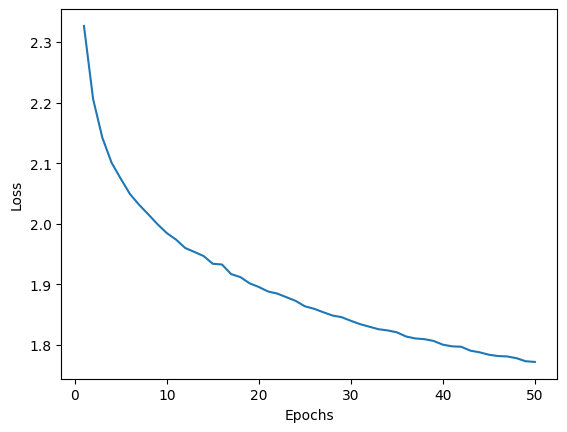

In [111]:
# 各エポックごとのlossのプロット
plt.plot(range(1, epochs+1), epoch_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

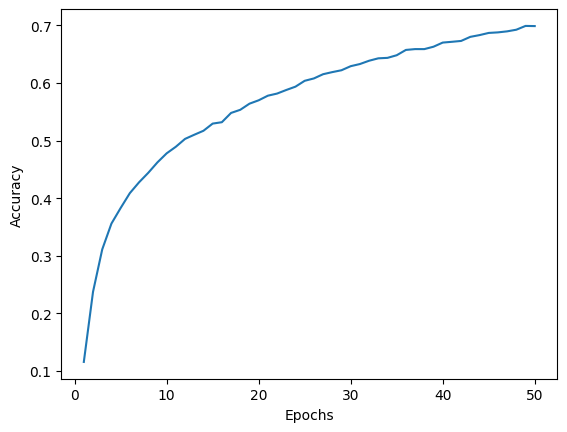

In [112]:
# 各エポックごとのaccuracyのプロット
plt.plot(range(1, epochs+1), epoch_accuracy_list)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [113]:
# テスト
model.eval()
correct = 0 #正解数
total = 0 #バッチサイズの合計
with torch.no_grad(): #勾配計算不可 (メモリの削減, requires_grad = False)
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  #バッチをGPUに移動
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1) #(最大値, 最大値のインデックス)を返す
        total += labels.size(0) #バッチサイズ
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.6605


In [ ]:
# Animals-10におけるCNNを用いた予測は, データ数の偏りによる影響が大きい
'''
【正解率の比較】

       オ ン ラ イ ン
         〇    ×
オ
フ  〇  69.1  66.0
ラ
イ  ×   62.9  64.8
ン
'''

In [ ]:
# フィードバック
'''
・画像そのものをもう少し可視化し、特徴を把握する
・誤った分類をしたデータの傾向や偏りを調べる
'''